# Grupo 2

Benitez, Macarena<br>
Castro Luna, Eduardo<br>
Gutierrez, Federico<br>
Wolowski, Mauro

# 1. Importación de Librerías y Configuraciones Iniciales

In [1]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from missingno import matrix, heatmap

from tp2_utils import *

# Configuracion de pandas

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/home/edu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


tp2_utils contiene funciones útiles para este trabajo, las que para limpieza de este notebook se prefirió mantener en una librería a importar.

En los submódulos de la librería podemos encontrar:
- df_basic_transformations: transformacions básicas al dataset identificadas en el trabajo anterior (con algunas modificaciones, como se detalla abajo). Estas son usadas en la sección 3
- variables_classification: diccionario con la clasificación de las variables.
- df_exploration_utils: Funciones útiles para explorar los datos.

# Importacón de base de datos original

In [2]:
# Cargar el dataset

url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df = pd.read_csv(url)

# Limpieza y Curación de los Datos No Numéricos

Aplicamos las mismas transformaciones realizadas en el Trabajo Práctico 1, con algunas modificaciones:

- Cambiar datos en formato serial de excel a formato dd/mm/yyyy
- Convertir todos los datos de tiempo a objetos pandas DataFrame, imputando los valores no válidos (cadenas del estilo 'no se midió) como NaT
- Pasamos todos los valores de campaña a minúscula. Eliminamos los que no correspondan a 'verano', 'otoño', 'invierno', 'primavera'
- En aquellas columnas que sólo admiten valores Asencia/Presencia -o similares-, imputamos como None aquellos valores que no correspondan a alguna de las categorías. Además, uniformamos los valores a 1 y 0 (a diferencia de lo hecho en el TP1, en el que seteamos a todos los valores válidos como'Ausente'/'Presente')
- Se imputan como None aquellos valores no válidos en calidad_de_agua
- Se imputan como NaN los valores no válidos en año -no hecho en TP 1-.
- Imputamos los datos faltantes relacionados con el Censo de 2022 y el Programa de Estudios del Conurbano usando la variable 'codigo':
    - Todas estas variables, salvo longitud y latitud, son imputadas usando sólo los dos primeros caracteres del código
    - Latitud y longitud no son imputadas, puesto que se observa que hay una correspondencia biunívoca entre latitud, longitud y código. No podemos asignar un único valor de latitud y longitud a cada municipio.

In [3]:
df1 = apply_date_correction_to_df(df) # Corrección columna 'fecha'
df2 = correct_campana(df1) # Corrección columna 'campaña'
df3 = correct_binary_categorical(df2) # Corrección de variables categóricas binarias
df4 = correct_calidad_del_agua(df3) # Corrección de variable calidad_de_agua
df5 = correct_ano(df4) # Corrección variable año
df6 = imputation_per_muni(df5)

# Guardamos el nuevo df para no tener que volver a correr todo esto cada vez
df6.to_csv('./aguas_primera_limpieza.csv', index=False)

Columna 'fecha' corregida
Columna 'camapaña' corregida
Columnas olores, color, espumas, mat_susp corregidas
Columna 'calidad_de_agua' corregida
Columna 'año' corregida
Imputación de variables de Censo y Programa de Conurbano -excepto longitud y latitud- usando código realizada


/home/edu/Facultad/DiploDatos/mentorias/TP2/tp2_utils/df_basic_transformations_utils.py:46: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df1['campaña'].astype(str).str.contains(patron, na=False)


Hasta acá las cosas pasadas en limpio. Lo de abajo no es para la versión final del trabajo, sino que son algunas exploraciones y pruebas.Faltan:
- Todas las variables numéricas, pues aún no decidimos qué hacer con los '<', '>'
- Actividad principal: Si decidimos descartarla, no hacemos nada. Lo único a considerar es que hay actividades mencionadas acá que no están entre las variables ordinales de actividad (ver dudas).

# Limpieza y Curación de los Variables Numéricas

**colif_fecales_ufc_100ml:** Idenfiticamos un valor outlier, y valores con '<', '>'.

In [4]:
compare_comparison_values(df6, 'colif_fecales_ufc_100ml')

colif_fecales_ufc_100ml 

colif_fecales_ufc_100ml_comparison  colif_fecales_ufc_100ml_value
>                                   100000.0                         1
Name: count, dtype: int64
Mínimo: 1.0, Máximo: 4200000.0

---------------------------------------------------


# Pruebasss


In [17]:
# Veamos para cuales valores de 'codigo' tenemos valores no nulos de longitud y latitud
codigos = df6['codigo'].unique()
for cod in codigos:
    df_filttered = df6[df6['codigo'] == cod]
    print(f"=========\n{cod}\n==========")
    print(f"Latitudes:\n{df_filttered['latitud'].unique()}")
    print(f"Longitudes:\n{df_filttered['longitud'].unique()}\n")

AV051
Latitudes:
[nan]
Longitudes:
[nan]

AV052
Latitudes:
[nan]
Longitudes:
[nan]

AV053
Latitudes:
['-34.662.789']
Longitudes:
['-58.296.669']

AV054
Latitudes:
['-34.63']
Longitudes:
['-58.328.339']

AV055
Latitudes:
[nan]
Longitudes:
[nan]

BS091
Latitudes:
['-34.873.061']
Longitudes:
['-57.810.561']

BS092
Latitudes:
['-34.855.808']
Longitudes:
['-57.838.144']

BS093
Latitudes:
[nan]
Longitudes:
[nan]

BS094
Latitudes:
[nan]
Longitudes:
[nan]

BS095
Latitudes:
[nan]
Longitudes:
[nan]

BZ077
Latitudes:
[nan]
Longitudes:
[nan]

BZ078
Latitudes:
['-34.744.169']
Longitudes:
['-58.177.231']

BZ080
Latitudes:
['-34.753']
Longitudes:
['-58.108.281']

CA CU01
Latitudes:
['-34.535.878']
Longitudes:
['-58.445.933']

CA CU02
Latitudes:
['-34.537.272']
Longitudes:
['-58.448.339']

CA CU03
Latitudes:
['-34.538.686']
Longitudes:
['-58.445.589']

CA CU04
Latitudes:
['-34.539.667']
Longitudes:
['-58.443.781']

CA CU05
Latitudes:
['-34.540.675']
Longitudes:
['-584.419']

CA041
Latitudes:
[nan]
Lon

In [14]:
muni_codes = ['AV', 'BS', 'BZ', 'CA', 'EN', 'QU', 'SF', 'SI', 'TI', 'VL', 'AC']
censo = (
    'gobierno_local',
    'latitud',
    'longitud',
    'Poblacion_partido',
    'Personas_con_cloacas',
    'Actividad_principal',
    'Agricultura, ganadería, caza y silvicultura',
    'Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos',
    'Explotación de minas y canteras',
    'Industria Manufacturera',
    'Electricidad, gas y agua',
    'Construcción',
    'Servicios'
)

for code in muni_codes:
    print(f"########\n{code}\n########\n\n")
    df_filtrado = df6[df6['codigo'].str.contains(code, na=False)]
    df_filtrado_orig = df5[df5['codigo'].str.contains(code, na=False)]
    for col in censo:
        print(f'=======\n{col}\n========\nModificado:\n{df_filtrado[col].unique()}\n\nOriginal\n{df_filtrado_orig[col].unique()}\n')

########
AV
########


gobierno_local
Modificado:
['Avellaneda']

Original
[nan 'Avellaneda']

latitud
Modificado:
[nan '-34.662.789' '-34.63']

Original
[nan '-34.662.789' '-34.63']

longitud
Modificado:
[nan '-58.296.669' '-58.328.339']

Original
[nan '-58.296.669' '-58.328.339']

Poblacion_partido
Modificado:
['367.554']

Original
[nan '367.554']

Personas_con_cloacas
Modificado:
['289.059']

Original
[nan '289.059']

Actividad_principal
Modificado:
['"Producción de electricidad, gas y agua"']

Original
[nan '"Producción de electricidad, gas y agua"']

Agricultura, ganadería, caza y silvicultura
Modificado:
[3.]

Original
[nan  3.]

Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos
Modificado:
[3.]

Original
[nan  3.]

Explotación de minas y canteras
Modificado:
[3.]

Original
[nan  3.]

Industria Manufacturera
Modificado:
[2.]

Original
[nan  2.]

Electricidad, gas y agua
Modificado:
[1.]

Original
[nan  1.]

Construcción
Modificado:
[5.]

Original
[n

In [5]:
classifier = VariablesClassification()
var_list = [var for var in classifier.censo if not var in ["latitud", "longitud"]]
print(len(var_list))

11


In [12]:
df['gobierno_local'].unique()

array([nan, 'Avellaneda', 'Berisso', 'Berazategui', 'CABA', 'Ensenada',
       'Quilmes', 'San Fernando', 'San Isidro', 'Tigre', 'Vicente López'],
      dtype=object)

In [52]:
codes = df['codigo'].unique()
print(codes)
print(len(codes))

['AV051' 'AV052' 'AV053' 'AV054' 'AV055' 'BS091' 'BS092' 'BS093' 'BS094'
 'BS095' 'BZ077' 'BZ078' 'BZ080' 'CA CU01' 'CA CU02' 'CA CU03' 'CA CU04'
 'CA CU05' 'CA041' 'CA044' 'CA046' 'CA047' 'EN AD' 'EN-adic' 'EN081'
 'EN082' 'EN083' 'EN084' 'QU061' 'QU062' 'QU063' 'SF015' 'SI021' 'SI022'
 'SI023' 'SI024' 'TI001' 'TI002' 'TI003' 'TI004' 'TI005' 'TI006' 'TI007'
 'TI008' 'TI009' 'VL031' 'VL032' 'VL033' 'EN-extra' 'AC001']
50


In [53]:
latttid = df['latitud'].unique()
print(latttid)
print(len(latttid))

[nan '-34.662.789' '-34.63' '-34.873.061' '-34.855.808' '-34.744.169'
 '-34.753' '-34.535.878' '-34.537.272' '-34.538.686' '-34.539.667'
 '-34.540.675' '-34.547.089' '-34.563.231' '-34.612.761' '-34.781.253'
 '-34.820.711' '-34.833.911' '-3.469.195' '-34.438.919' '-34.465.281'
 '-34.484.169' '-34.408.061' '-34.384.169' '-34.375.561' '-34.505.531']
26


In [54]:
longg = df['longitud'].unique()
print(longg)
print(len(longg))

[nan '-58.296.669' '-58.328.339' '-57.810.561' '-57.838.144' '-58.177.231'
 '-58.108.281' '-58.445.933' '-58.448.339' '-58.445.589' '-58.443.781'
 '-584.419' '-58.430.231' '-58.404.119' '-58.340.611' '-58.008.481'
 '-57.965.319' '-57.880.211' '-58.253.889' '-58.536.519' '-58.493.061'
 '-5.847.945' '-58.590.839' '-58.632.511' '-58.558.619' '-58.473.719']
26


In [10]:
muni_codes = ['AV', 'BS', 'BZ', 'CA', 'EN', 'QU', 'SF', 'SI', 'TI', 'VL', 'AC']
censo = (
    'gobierno_local',
    'latitud',
    'longitud',
    'Poblacion_partido',
    'Personas_con_cloacas',
    'Actividad_principal',
    'Agricultura, ganadería, caza y silvicultura',
    'Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos',
    'Explotación de minas y canteras',
    'Industria Manufacturera',
    'Electricidad, gas y agua',
    'Construcción',
    'Servicios'
)

for code in muni_codes:
    print(f"=======\n{code}\n=======")
    df_filtrado = df5[df5['codigo'].str.contains(code, na=False)]
    for col in censo:
        print(f'{col}:\n{df_filtrado[col].unique()}\n')

AV
gobierno_local:
[nan 'Avellaneda']

latitud:
[nan '-34.662.789' '-34.63']

longitud:
[nan '-58.296.669' '-58.328.339']

Poblacion_partido:
[nan '367.554']

Personas_con_cloacas:
[nan '289.059']

Actividad_principal:
[nan '"Producción de electricidad, gas y agua"']

Agricultura, ganadería, caza y silvicultura:
[nan  3.]

Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos:
[nan  3.]

Explotación de minas y canteras:
[nan  3.]

Industria Manufacturera:
[nan  2.]

Electricidad, gas y agua:
[nan  1.]

Construcción:
[nan  5.]

Servicios:
[nan  6.]

BS
gobierno_local:
['Berisso' nan]

latitud:
['-34.873.061' '-34.855.808' nan]

longitud:
['-57.810.561' '-57.838.144' nan]

Poblacion_partido:
['100.930' nan]

Personas_con_cloacas:
['47.630' nan]

Actividad_principal:
['"Industria Manufacturera"' nan]

Agricultura, ganadería, caza y silvicultura:
[nan]

Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos:
[nan]

Explotación de minas y

In [43]:
muni_codes = ['AV', 'BS', 'BZ', 'CA', 'EN', 'QU', 'SF', 'SI', 'TI', 'VL', 'AC']
censo = (
    'gobierno_local',
    'latitud',
    'longitud',
    'Poblacion_partido',
    'Personas_con_cloacas',
    'Actividad_principal',
    'Agricultura, ganadería, caza y silvicultura',
    'Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos',
    'Explotación de minas y canteras',
    'Industria Manufacturera',
    'Electricidad, gas y agua',
    'Construcción',
    'Servicios'
)

for code in muni_codes:
    print(f'########################\n{code}\n#################\n')
    df_filtrado = df5[df5['codigo'].str.contains(code, na=False)]
    latitudes = df_filtrado['latitud'].unique()
    longitudes = df_filtrado['longitud'].unique()
    print("=====\nlatitutdes\n=====")
    for lat in latitudes:
        df_filt_por_lat = df5[df5['latitud'] == lat]
        print(f"{lat}\n:{df_filt_por_lat['codigo'].unique()}")
    print("=====\nlongitudes\n=====")
    for long in longitudes:
        df_filt_por_long = df5[df5['longitud'] == long]
        print(f"{long}\n:{df_filt_por_long['codigo'].unique()}")

########################
AV
#################

=====
latitutdes
=====
nan
:[]
-34.662.789
:['AV053']
-34.63
:['AV054']
=====
longitudes
=====
nan
:[]
-58.296.669
:['AV053']
-58.328.339
:['AV054']
########################
BS
#################

=====
latitutdes
=====
-34.873.061
:['BS091']
-34.855.808
:['BS092']
nan
:[]
=====
longitudes
=====
-57.810.561
:['BS091']
-57.838.144
:['BS092']
nan
:[]
########################
BZ
#################

=====
latitutdes
=====
nan
:[]
-34.744.169
:['BZ078']
-34.753
:['BZ080']
=====
longitudes
=====
nan
:[]
-58.177.231
:['BZ078']
-58.108.281
:['BZ080']
########################
CA
#################

=====
latitutdes
=====
-34.535.878
:['CA CU01']
-34.537.272
:['CA CU02']
-34.538.686
:['CA CU03']
-34.539.667
:['CA CU04']
-34.540.675
:['CA CU05']
nan
:[]
-34.547.089
:['CA044']
-34.563.231
:['CA046']
-34.612.761
:['CA047']
=====
longitudes
=====
-58.445.933
:['CA CU01']
-58.448.339
:['CA CU02']
-58.445.589
:['CA CU03']
-58.443.781
:['CA CU04']
-584.419
:[

In [44]:
def tabla_contingencia(serie_x : pd.Series, serie_y : pd.Series, titulo : str = None, x_label: None | str = None, y_label: None | str = None, x_size : float = 20, y_size : float = 16):
    contingency_table = pd.crosstab(serie_y, serie_x)
    plt.figure(figsize=(x_size, y_size))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
    plt.title(titulo)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

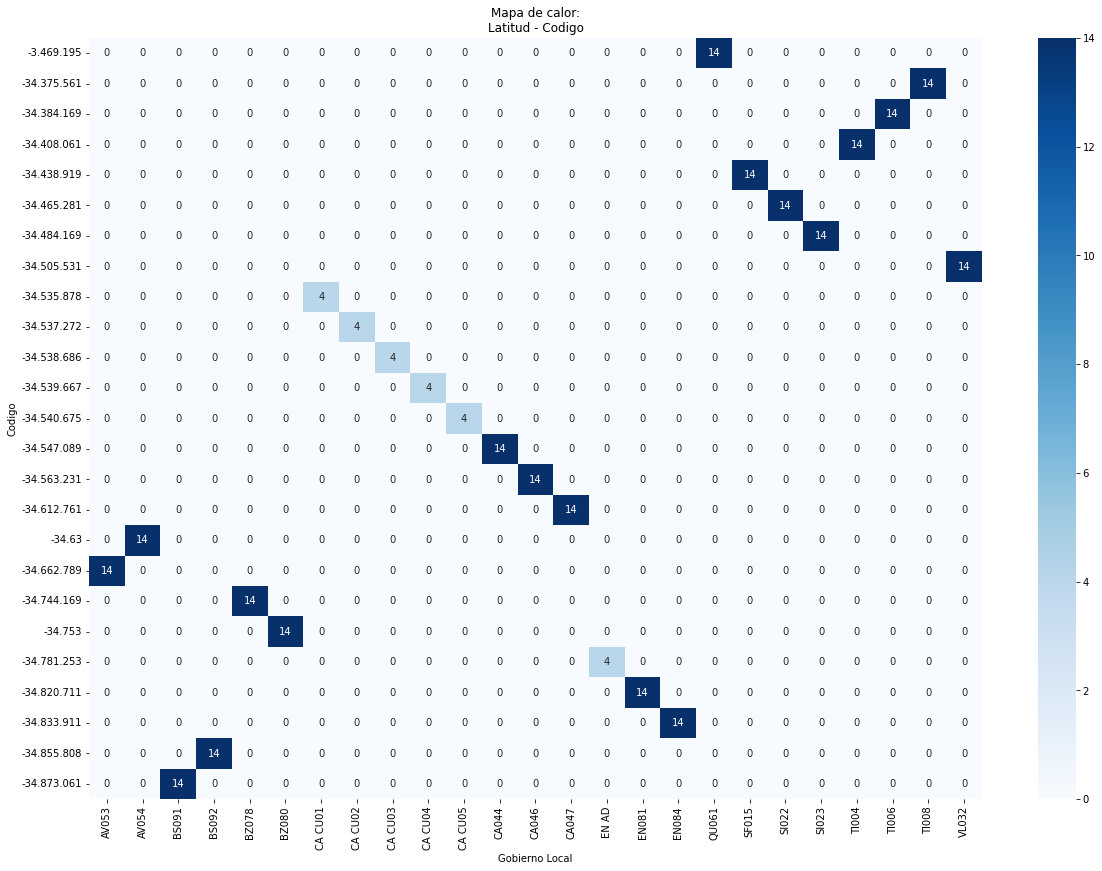

In [50]:
tabla_contingencia(df5['codigo'], df5['latitud'], titulo = "Mapa de calor:\nLatitud - Codigo", x_label = "Gobierno Local", y_label = "Codigo", x_size = 20, y_size = 14)

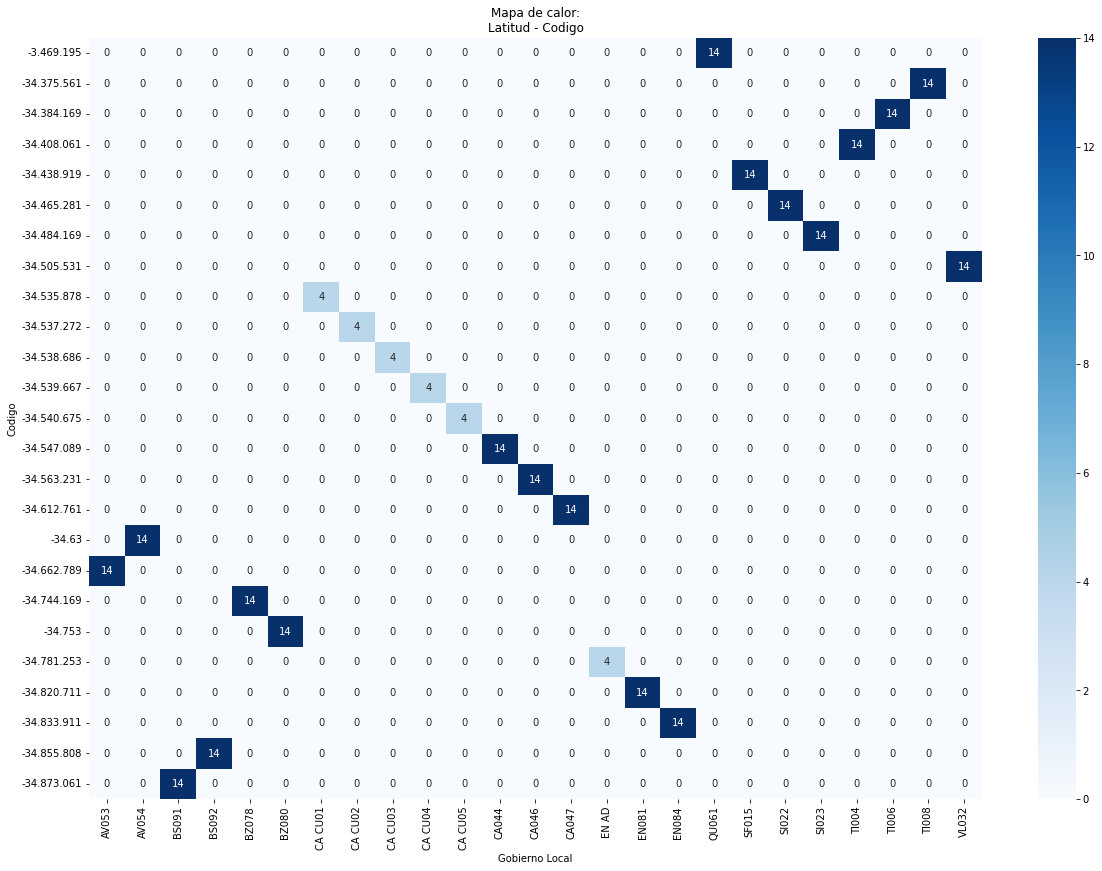

In [51]:
tabla_contingencia(df5['codigo'], df5['latitud'], titulo = "Mapa de calor:\nLatitud - Codigo", x_label = "Gobierno Local", y_label = "Codigo", x_size = 20, y_size = 14)

<Axes: >

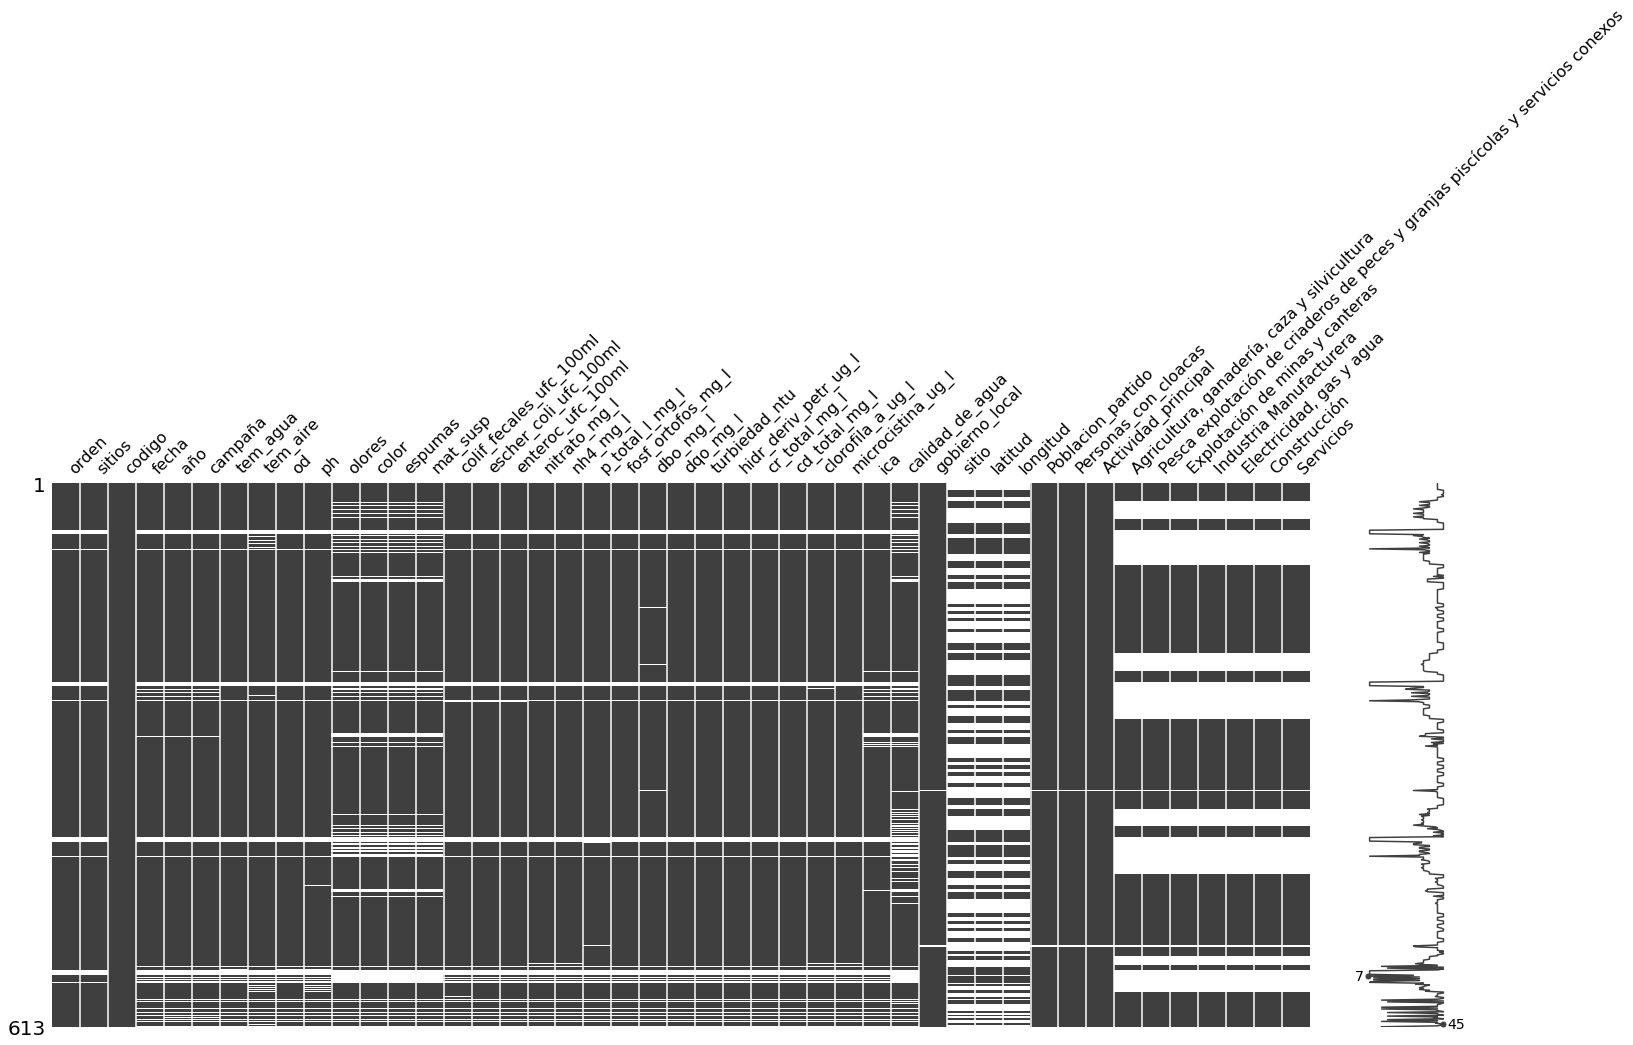

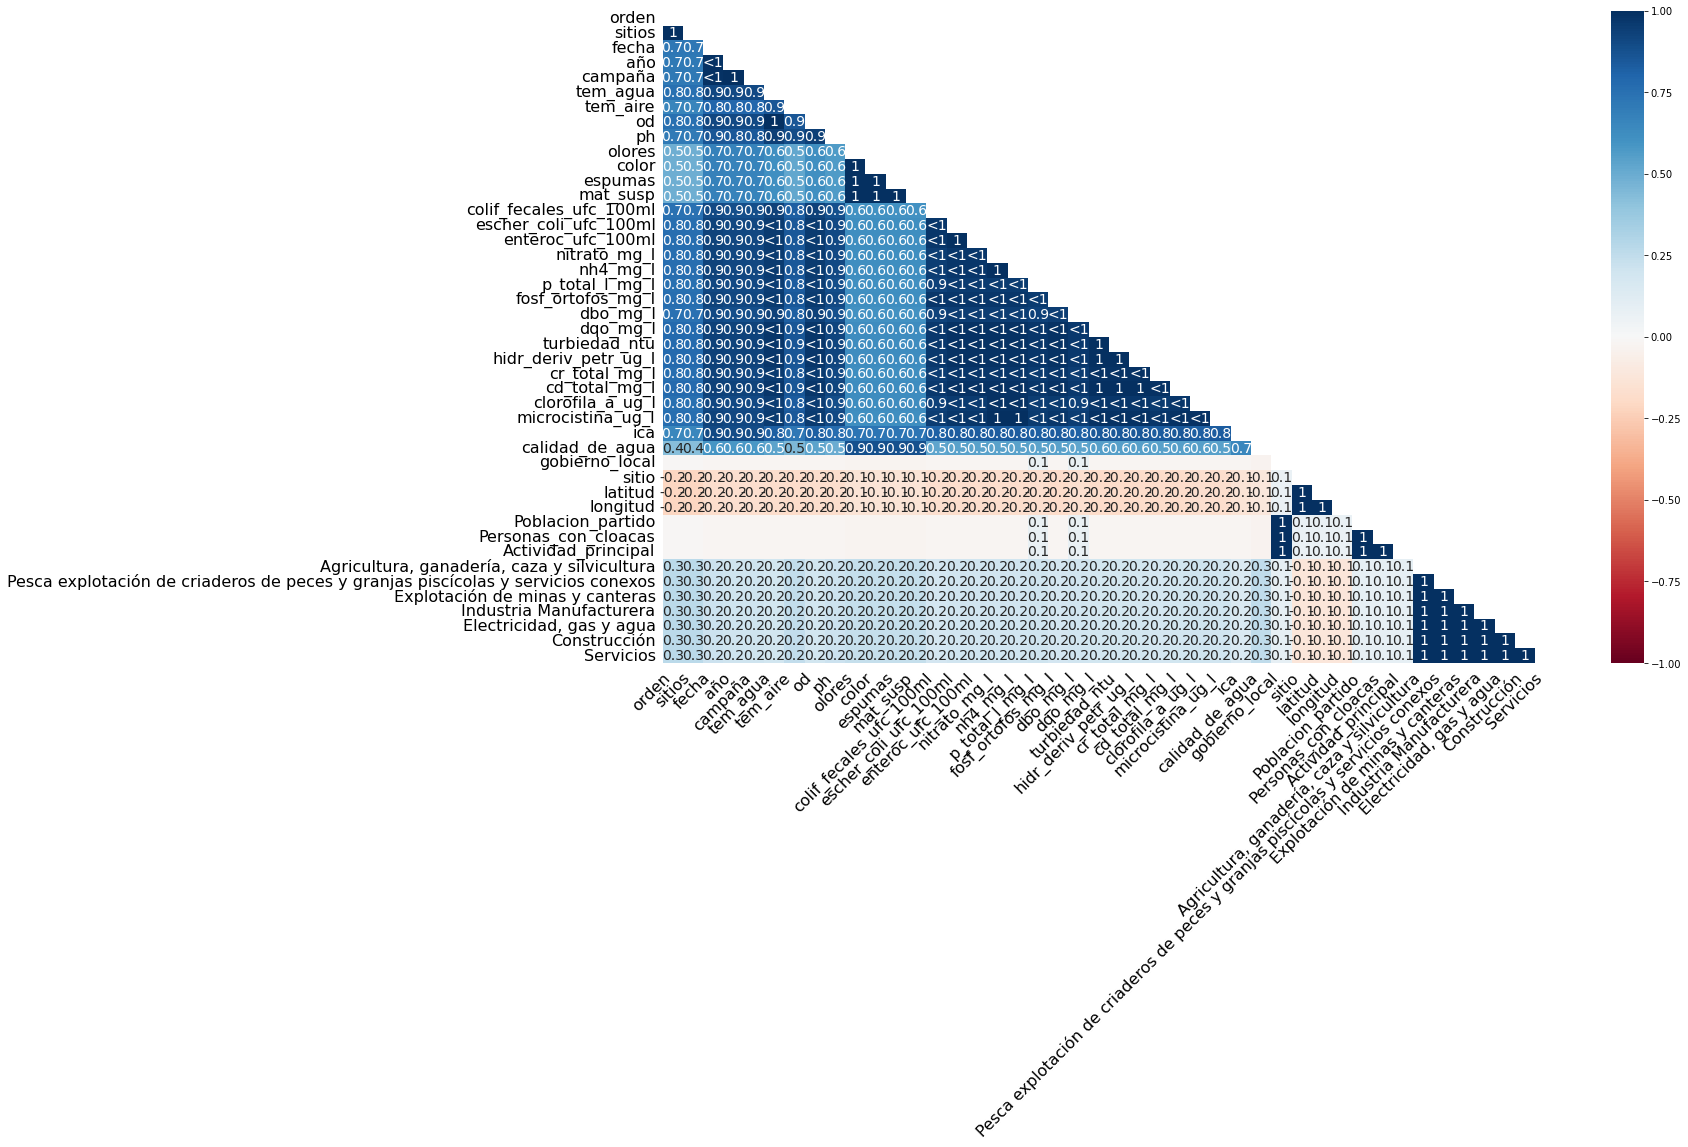

In [5]:
matrix(df6)
heatmap(df6)

# Dudas

**1. Para descartar Actividad_Principal**
Notar que tenemos actividades en actividad principal que no están entre las otras:<br>
       siderúrgica y refineria de petroleo
       Actividad náutica
       La industria metalúrgica y la actividad maderera

In [10]:
df['Actividad_principal'].unique()

array([nan, '"Producción de electricidad, gas y agua"',
       '"Industria Manufacturera"',
       '"Agricultura, ganadería, caza y silvicultura"',
       '"servicios inmobiliarios, financieros y comercio"',
       '"siderúrgica y refineria de petroleo"',
       'Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos',
       '"Actividad náutica"',
       '"Explotación de minas y canteras con el 11,53%. Asimismo, es el segundo en participación en el rubro construcción"',
       '"La industria metalúrgica y la actividad maderera"'], dtype=object)

**Qué onda CABA???** Es enorme, no se que sentido tiene equiparar sus datos del censo y Programa del Conurbano con los de los municipios, mucho más acotados.

# Funciones

In [31]:
def extract_comparison_values(df, column_name):
    """
    Extract numeric values from strings with '>x' or '<x' patterns in a DataFrame column.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        column_name (str): Name of the column to process
    
    Returns:
        pd.DataFrame: Copy of original DataFrame with two new columns:
            - '[column_name]_comparison': contains '>', '<', or None
            - '[column_name]_value': contains the extracted numeric value or None
    """
    # Create new df to store the values of interest
    columnas = [f'{column_name}_comparison', f'{column_name}_value']
    result_df = pd.DataFrame(columns=columnas)
    
    # Regular expression to match patterns like >x, <x, >x.y, <x.y
    pattern = re.compile(r'^([<>])\s*(\d+\.?\d*)$')
    
    for value in df[column_name]:
        if pd.isna(value) or not isinstance(value, str):
            continue
            
        match = pattern.match(str(value).strip())
        if match:
            comparison_op = match.group(1)  # Either '>' or '<'
            numeric_value = float(match.group(2))  # Convert to float
            
            # Añadimos nuevo registro al result_df
            nuevo_registro = {
                f'{column_name}_comparison': comparison_op,  # Operador de comparación
                f'{column_name}_value': numeric_value        # Valor numérico
            }
            result_df.loc[len(result_df)] = nuevo_registro
    
    return result_df

In [11]:
# Patrón para valores como <n
patron = re.compile(r'^[<>]\d*\.?\d+$')  # Acepta <3, <3.5, etc.
columns_with_less_more = []

print("Porcentaje de:")
print("Columna\t\t\t\tCeros\tNo numéricos\tCon forma '><x'\tNulos\tVacíos")
print("______________________________________________________________________________________")
for col in numericas:
    # Intentar convertir a numérico
    valores_numericos = pd.to_numeric(df[col], errors='coerce')
    no_numericos = df[col][valores_numericos.isna() & df[col].notna()]
    
    # Contar cantidad de valores ...
    cantidad_no_numericos = len(no_numericos) # no numéricos
    cantidad_ceros = (df[col] == 0).sum() # iguales a cero
    vacios = df[col].str.strip().eq("").sum() # Vacíos -carácter "" o algún tipo de espacio-
    nulos = df[col].isnull().sum() # Nulos
    if cantidad_no_numericos != 0:
        valores_menor_que = no_numericos.apply(lambda x: bool(patron.match(str(x)))).sum() # Valores de forma '<x'
    else:
        valores_menor_que = 0
        
    # Añado columna a lista de columnas con valores de tipo '><x'    
    if valores_menor_que != 0:
        columns_with_less_more.append(col)
    
    # Cálculo de porcentajes
    total = len(df)
    porc_ceros = cantidad_ceros*100/total
    porc_no_numericos = (cantidad_no_numericos-valores_menor_que)*100/total
    porc_menores_que = valores_menor_que*100/total
    porc_nulos = nulos*100/total
    porc_vacios = vacios*100/total
    print(f"{col:<{25}}\t{porc_ceros:5.2f}\t   {porc_no_numericos:5.2f}\t    {porc_menores_que:5.2f}\t{porc_nulos:5.2f}\t{porc_vacios:5.2f}")

Porcentaje de:
Columna				Ceros	No numéricos	Con forma '><x'	Nulos	Vacíos
______________________________________________________________________________________
tem_agua                 	 0.00	   12.89	     0.00	 6.69	 0.00
tem_aire                 	 0.00	   12.72	     0.00	 8.48	 0.00
od                       	 0.00	   16.15	     0.00	 6.69	 0.00
ph                       	 0.00	   20.23	     0.00	 7.50	 0.00
colif_fecales_ufc_100ml  	 0.00	   14.19	     0.16	 6.85	 0.00
escher_coli_ufc_100ml    	 0.00	   13.21	     0.00	 6.53	 0.00
enteroc_ufc_100ml        	 0.00	   13.21	     0.00	 6.53	 0.00
nitrato_mg_l             	 0.00	    8.97	     7.83	 6.53	 0.00
nh4_mg_l                 	 0.00	    8.32	     7.34	 6.53	 0.00
p_total_l_mg_l           	 0.00	   13.05	     2.45	 6.69	 0.00
fosf_ortofos_mg_l        	 0.00	   20.39	     7.83	 6.53	 0.00
dbo_mg_l                 	 0.00	   22.68	    15.82	 6.85	 0.00
dqo_mg_l                 	 0.00	   19.41	    37.36	 6.36	 0.00
turbiedad_ntu       

In [36]:
df2["fecha"].value_counts()

fecha
2023-08-23    43
2021-10-27    42
2022-05-04    42
2021-08-25    42
2022-08-23    42
2023-05-10    42
2023-02-22    42
2022-02-23    42
2024-04-08    42
2023-11-14    42
2021-05-19    41
2021-02-24    41
2022-10-31    37
2024-11-27    23
2024-12-02     5
2024-04-12     1
Name: count, dtype: int64

In [45]:
for col in columns_with_less_more:
    print(col, "\n")
    result_df = extract_comparison_values(df, col)
    print(result_df.value_counts())
    numric = pd.to_numeric(df[col], errors='coerce')
    print(f"Mínimo: {numric.min()}, Máximo: {numric.max()}")
    print("\n---------------------------------------------------")

colif_fecales_ufc_100ml 

colif_fecales_ufc_100ml_comparison  colif_fecales_ufc_100ml_value
>                                   100000.0                         1
Name: count, dtype: int64
Mínimo: 1.0, Máximo: 4200000.0

---------------------------------------------------
nitrato_mg_l 

nitrato_mg_l_comparison  nitrato_mg_l_value
<                        2.0                   36
                         44.0                   8
                         1.0                    4
Name: count, dtype: int64
Mínimo: 1.1, Máximo: 39.4

---------------------------------------------------
nh4_mg_l 

nh4_mg_l_comparison  nh4_mg_l_value
<                    0.05              27
                     0.01              15
                     0.78               2
                     0.10               1
Name: count, dtype: int64
Mínimo: 0.049, Máximo: 39.0

---------------------------------------------------
p_total_l_mg_l 

p_total_l_mg_l_comparison  p_total_l_mg_l_value
<                         